In [1]:
 #===================================================== Import libraries ================================================================================

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn 
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# ================================================= Flexible Layer ================================================================================

    
class FlexiLayer(nn.Module): # class FlexiLayer(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        super(FlexiLayer, self).__init__()
        
        self.t_1 = nn.Conv2d(self.in_channels, self.out_channels, self.kernel_size, self.stride, self.padding)
        self.t_2 = nn.MaxPool2d(self.kernel_size, self.stride, self.padding) # get max result with the same kernel size
        self.m = nn.Sigmoid()
        
        self.threshold1 = Variable(torch.randn((1, self.out_channels, 30, 30)))
        
        self.thresh_mean = []
        
    def forward(self, t):
        
        self.threshold1.expand(t.size(0), self.out_channels, 30, 30)
        
        
        cond = torch.sub(self.t_2(t), self.threshold1.cuda())
        t_2_2 = self.m(cond*50)*self.t_2(t) # 
        t_1_1 = self.m(cond*(-50))*self.t_1(t) # 
        t = torch.add(t_2_2, t_1_1)
        
        return t

    # ================================================= VGG-16 Network ================================================================================
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16,self).__init__()

        self.block1 = nn.Sequential(
                      nn.Conv2d(in_channels = 3,out_channels = 64,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(64),
                      nn.ReLU(),
                      FlexiLayer(in_channels = 64,out_channels = 64,kernel_size = 3, padding =0),
                      nn.BatchNorm2d(64),
                      nn.ReLU(),
                      #nn.MaxPool2d(kernel_size=2, stride=2),
                      nn.Dropout2d(0.3))

        self.block2 = nn.Sequential(
                      nn.Conv2d(in_channels = 64,out_channels = 128,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(128),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 128,out_channels = 128,kernel_size = 3, padding =1),
                      nn.BatchNorm2d(128),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2),
                      nn.Dropout2d(0.4))

        self.block3 = nn.Sequential(
                      nn.Conv2d(in_channels = 128,out_channels = 256,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(256),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 256,out_channels = 256,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(256),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 256,out_channels = 256,kernel_size = 3, padding =1),
                      nn.BatchNorm2d(256),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2),
                      nn.Dropout2d(0.4))

        self.block4 = nn.Sequential(
                      nn.Conv2d(in_channels = 256,out_channels = 512,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3, padding =1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2) ,
                      nn.Dropout2d(0.4))

        self.block5 = nn.Sequential(
                      nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3, padding =1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2),
                      nn.Dropout2d(0.5) )

        self.fc =     nn.Sequential(
                      nn.Linear(512,100),
                      nn.Dropout(0.5),
                      nn.BatchNorm1d(100),
                      nn.ReLU(),
                      nn.Dropout(0.5),
                      nn.Linear(100,10), )




    def forward(self,x):
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = out.view(out.size(0),-1)
        out = self.fc(out)

        return out


In [2]:
 #===================================================== Import libraries ================================================================================

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn 
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

#from models.VGG16_with_flex_v5 import *


# =================================================== Prepare the dataset ===============================================================================

mean_cifar10 = [0.485, 0.456, 0.406]  # Mean and Std value hase been taken from a github implmentation online.
std_cifar10 = [0.229, 0.224, 0.225]
batch_size = 100
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean_cifar10,std_cifar10),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_cifar10,std_cifar10),
])

trainset = torchvision.datasets.CIFAR10(root='../FlexibleCNNs/data', train=True, download= True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../FlexibleCNNs/data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') # 10 Classes of the cifar-10

# ========================================== Visualising the dataset ==========================================================================
std= torch.FloatTensor(std_cifar10)
mean = torch.FloatTensor(mean_cifar10)
mean = mean[:,None,None]
std = std[:,None,None]
def imshow(img):
    print(img.size())
    img = img*std + mean     # unnormalize
    
    npimg = img.numpy()
    
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Files already downloaded and verified
Files already downloaded and verified
torch.Size([3, 36, 138])
horse  frog   dog  ship


In [3]:
# =============================================================== Model initialisation, Loss function and Optimizer =====================================
model = VGG16()
if torch.cuda.is_available():
    model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.001,momentum = 0.9,weight_decay = 0.006)
schedule = torch.optim.lr_scheduler.StepLR(optimizer,step_size=20,gamma = 0.7)

total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} trainable parameters.')

14,775,646 total parameters.
14,775,646 trainable parameters.


Epoch:  0   Loss:  1080.2519220113754   Train Accuracy : 18.102


Test accuracy: 23 %
Epoch:  1   Loss:  952.502119064331   Train Accuracy : 27.31


Test accuracy: 31 %
Epoch:  2   Loss:  885.8307869434357   Train Accuracy : 33.404


Test accuracy: 41 %
Epoch:  3   Loss:  835.9750851392746   Train Accuracy : 37.662


Test accuracy: 45 %
Epoch:  4   Loss:  797.1777278184891   Train Accuracy : 41.81


Test accuracy: 49 %
Epoch:  5   Loss:  757.4321074485779   Train Accuracy : 45.984


Test accuracy: 54 %
Epoch:  6   Loss:  717.6093529462814   Train Accuracy : 49.804


Test accuracy: 58 %
Epoch:  7   Loss:  683.8819860219955   Train Accuracy : 53.024


Test accuracy: 60 %
Epoch:  8   Loss:  651.1314281225204   Train Accuracy : 55.63


Test accuracy: 61 %
Epoch:  9   Loss:  624.6597764492035   Train Accuracy : 58.118


Test accuracy: 64 %
Epoch:  10   Loss:  602.9231666326523   Train Accuracy : 60.134


Test accuracy: 66 %
Epoch:  11   Loss:  578.3125347495079   Train Accuracy : 62.13


Te

Test accuracy: 89 %
Epoch:  96   Loss:  113.6350276991725   Train Accuracy : 95.812


Test accuracy: 89 %
Epoch:  97   Loss:  112.23479285091162   Train Accuracy : 95.878


Test accuracy: 89 %
Epoch:  98   Loss:  113.12839578837156   Train Accuracy : 95.73


Test accuracy: 89 %
Epoch:  99   Loss:  109.37753860652447   Train Accuracy : 95.988


Test accuracy: 88 %
Epoch:  100   Loss:  99.7830208465457   Train Accuracy : 96.606


Test accuracy: 89 %
Epoch:  101   Loss:  96.29569982737303   Train Accuracy : 96.828


Test accuracy: 89 %
Epoch:  102   Loss:  92.14032465964556   Train Accuracy : 97.104


Test accuracy: 89 %
Epoch:  103   Loss:  91.63061649352312   Train Accuracy : 97.2


Test accuracy: 89 %
Epoch:  104   Loss:  90.8162287697196   Train Accuracy : 97.118


Test accuracy: 89 %
Epoch:  105   Loss:  88.37750746309757   Train Accuracy : 97.348


Test accuracy: 89 %
Epoch:  106   Loss:  86.97694388777018   Train Accuracy : 97.31


Test accuracy: 89 %
Epoch:  107   Loss:  85.520038

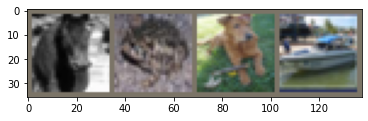

In [4]:
# ======================== Function to get the test accuracy ===============================================================================
def test():
    correct = 0
    total = 0
    model.train(False)
    with torch.no_grad():
        for i,(images,labels)in enumerate(testloader):
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            outputs = model(Variable(images))
            labels = Variable(labels)
            _,predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted.eq(labels)).sum().item()
    print('Test accuracy: %d %%' % (
    100 * correct / total))
    return 100*(correct/total)

#======================================================= Training =========================================================================
num_epochs = 152  # Train for 150 epochs
start_epoch = 0

total_step = len(trainloader)
train_loss = []  # Store the train_loss per epoch
test_accuracy = [] # Store the test_accuracy per epoch
for epoch in range(start_epoch,num_epochs+1):
    model.train(True)
    epoch_loss  = 0
    i_count = 0
    acc_total = 0
    for i,(images,labels) in enumerate(trainloader):
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        labels = Variable(labels)
        optimizer.zero_grad()
        outputs = model(Variable(images))
        loss = criterion(outputs,labels)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        _,predicted = outputs.max(1)
        denom = labels.size(0)
        correct = predicted.eq(labels).sum().item()
        acc = 100*(correct/denom)
        acc_total += acc
        i_count = i_count + 1
    
    #if(i%20 == 0):  # Print the loss per 20 iterations
      #print("Epoch: ",epoch," ","Iteration: ",i," loss: ",loss.item()," Train_iter Accuracy: ",acc)
    schedule.step()
    train_loss.append(epoch_loss)
    print("Epoch: ",epoch," ","Loss: ",epoch_loss," ","Train Accuracy :",acc_total/i_count) # Print train accuracy per epoch
    print('\n')
    test_acc = test()      # Print the test accuracy per epoch
    test_accuracy.append(test_acc)

    if(epoch%50 == 0):       # Save the model every 50 epoch
        state = {
            'model': model.state_dict(),
            'acc' : test_acc,
            'optim':optimizer.state_dict(),
            'epoch' : epoch
        }
        path = './models/VGG16-flex-v5-block1-nnmodule_withdropout' + 'model_' + str(int(epoch)) +'_' + str(int(test_acc))+'.pth'
        torch.save(state,path)


In [5]:
#======================================= Testing ===================================================================================================
test_acc = test() # Test error
print(test_acc)

# Per class accuracy
class_correct = list(0. for i in range(10)) # Individual class error
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        if torch.cuda.is_available():
          images = images.cuda()
          labels = labels.cuda()
        images = Variable(images)
        labels = Variable(labels)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Test accuracy: 90 %
90.16999999999999
Accuracy of plane : 97 %
Accuracy of   car : 100 %
Accuracy of  bird : 81 %
Accuracy of   cat : 72 %
Accuracy of  deer : 89 %
Accuracy of   dog : 90 %
Accuracy of  frog : 92 %
Accuracy of horse : 100 %
Accuracy of  ship : 91 %
Accuracy of truck : 93 %


In [6]:
'''  
The image lies between [0,1] but since I have trained the whole network on normalized input, Therefore
the min_val = -2.117 and max_val = 2.64 and not {0,1}
'''

# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, -2.117, 2.64)
    # Return the perturbed image
    return perturbed_image

def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        #if init_pred.item() != target.item():
        #    continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        for i in range(0,len(final_pred)-1):
            if final_pred[i].sub(target[i]) == 0:
                correct += 1
                # Special case for saving 0 epsilon examples
                if (epsilon == 0) and (len(adv_examples) < 5):
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred[i], final_pred[i], adv_ex) )
            else:
                # Save some adv examples for visualization later
                if len(adv_examples) < 5:
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred[i], final_pred[i], adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [7]:
#evaluate model
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images.cuda())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum().item()

print('Accuracy on the test dataset is: %f %%' % (
    100 * correct / total))

Accuracy on the test dataset is: 90.170000 %


In [8]:
accuracies = []
examples = []
epsilons = [0, .05, .1, .15, .2, .25, .3]

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, testloader, eps)
    accuracies.append(acc)
    examples.append(ex)

CUDA Available:  True
Epsilon: 0	Test Accuracy = 8925 / 100 = 89.25
Epsilon: 0.05	Test Accuracy = 5696 / 100 = 56.96
Epsilon: 0.1	Test Accuracy = 5061 / 100 = 50.61
Epsilon: 0.15	Test Accuracy = 4822 / 100 = 48.22
Epsilon: 0.2	Test Accuracy = 4636 / 100 = 46.36
Epsilon: 0.25	Test Accuracy = 4415 / 100 = 44.15
Epsilon: 0.3	Test Accuracy = 4136 / 100 = 41.36


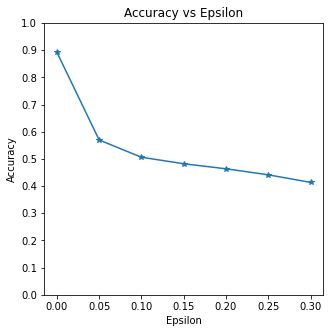

In [9]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, torch.tensor(accuracies).div(100), "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

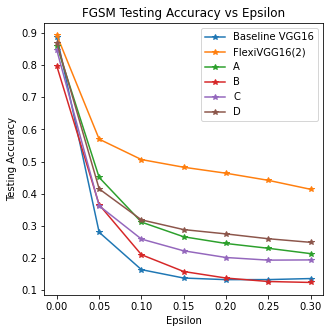

In [10]:
import matplotlib.pyplot as plt
import numpy as np

epsilons = [0, .05, .1, .15, .2, .25, .3]
accuracies = np.divide(accuracies, 100)
accuracies1 = [0.8881, 0.2799, 0.1636, 0.1375, 0.1325, 0.1327, 0.1359]
accuraciesA = [86.03,
45.05,
31.15,
26.59,
24.5,
23.01,
21.35,
]
accuraciesB = [79.62,
36.57,
21.01,
15.78,
13.75,
12.67,
12.38,
]
accuraciesC = [84.57,
36.22,
25.87,
22.22,
20.14,
19.32,
19.39,
]
accuraciesD = [86.99,
41.49,
31.85,
28.82,
27.48,
25.98,
24.86,
]
accuraciesA = np.divide(accuraciesA, 100)
accuraciesB = np.divide(accuraciesB, 100)
accuraciesC = np.divide(accuraciesC, 100)
accuraciesD = np.divide(accuraciesD, 100)
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies1, "*-", label = "Baseline VGG16")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.plot(epsilons, accuracies, "*-", label = "FlexiVGG16(2)")
plt.xticks(np.arange(0, .35, step=0.05))
plt.plot(epsilons, accuraciesA, "*-", label = "A")
plt.xticks(np.arange(0, .35, step=0.05))
plt.plot(epsilons, accuraciesB, "*-", label = "B")
plt.xticks(np.arange(0, .35, step=0.05))
plt.plot(epsilons, accuraciesC, "*-", label = "C")
plt.xticks(np.arange(0, .35, step=0.05))
plt.plot(epsilons, accuraciesD, "*-", label = "D")
plt.xticks(np.arange(0, .35, step=0.05))
#plt.plot(epsilons, accuracies3, "*-", label = "FlexiVGG16_batch_indep_100epochs")
plt.title("FGSM Testing Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Testing Accuracy")
plt.legend()
#plt.savefig('./figures/fgsm_testing_results.png', format='png')
plt.show()

In [11]:
#save test accuracy to plot


import pickle

with open('cifar_flex_withdropout_testaccuracy.pkl', 'wb') as f:
    pickle.dump(test_accuracy, f)